In [138]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180

In [139]:
import numpy as np
import matplotlib.lines as mlines

P = 19
A = -3
B = 5

# Following two functions for inverting number on field of integers modulo p are from
# https://andrea.corbellini.name/2015/05/23/elliptic-curve-cryptography-finite-fields-and-discrete-logarithms/
def extended_euclidean_algorithm(a, b):
    """
    Returns a three-tuple (gcd, x, y) such that
    a * x + b * y == gcd, where gcd is the greatest
    common divisor of a and b.

    This function implements the extended Euclidean
    algorithm and runs in O(log b) in the worst case.
    """
    s, old_s = 0, 1
    t, old_t = 1, 0
    r, old_r = b, a

    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t

    return old_r, old_s, old_t


def inverse_of(n, p):
    """
    Returns the multiplicative inverse of
    n modulo p.

    This function returns an integer m such that
    (n * m) % p == 1.
    """
    gcd, x, y = extended_euclidean_algorithm(n, p)
    assert (n * x + p * y) % p == gcd

    if gcd != 1:
        # Either n is 0, or p is not a prime number.
        raise ValueError(
            '{} has no multiplicative inverse '
            'modulo {}'.format(n, p))
    else:
        return x % p

    
class Point:
    def __init__(self, p, x=float('inf'), y=float('inf')):
        self.p = p
        self.x = x % p
        self.y = y % p
        
    def __repr__(self):
        return "Point(p={}, x={}, y={})".format(self.p, self.x, self.y)
    
    def __add__(self, other):
        assert type(other) is Point
        if self.x == other.x and self.y == other.y:
            return self.double()
        dx = other.x - self.x
        dy = other.y - self.y
        if dx == 0:
            return Point()
        slope = dy * inverse_of(dx, self.p)
        x = (slope ** 2) - self.x - other.x
        y = slope * x + (self.y - slope * self.x)
        x %= self.p
        y %= self.p
        return Point(self.p, x, -y)
    
    def double(self):
        slope = (3 * (self.x ** 2) + A) * inverse_of(2 * self.y, self.p)
        x = (slope ** 2) - (2 * self.x)
        y = slope * x + (self.y - slope * self.x)
        x %= self.p
        y %= self.p
        return Point(self.p, x, -y)
    
    def oppsite(self):
        return Point(self.p, self.x, -self.y)
    
    def np(self):
        return np.array([self.x, self.y])
    

In [190]:
import matplotlib.pyplot as plt

def enumerate_points(p):
    # TODO: this is silly way, maybe there's a better way
    for x in range(p):
        for y in range(p):
            if (y ** 2) % p == ((x ** 3) + A * x + B) % p:
                yield (x, y)

                
def plot_curve(p, a, b, ax):
    points = list(enumerate_points(p))
    points = np.array(points)
    # print(points)

    ax.scatter(points[:,0], points[:,1], zorder=5)
    ax.set_axisbelow(True)
    ax.grid()
    
    ax.set_ylim(top=p)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_xlim(right=p)

In [191]:
p1 = Point(P, 3, 2)
p0 = Point(P, 5, 18)
p2 = p0 + p1
p2

Point(p=19, x=18, y=11)

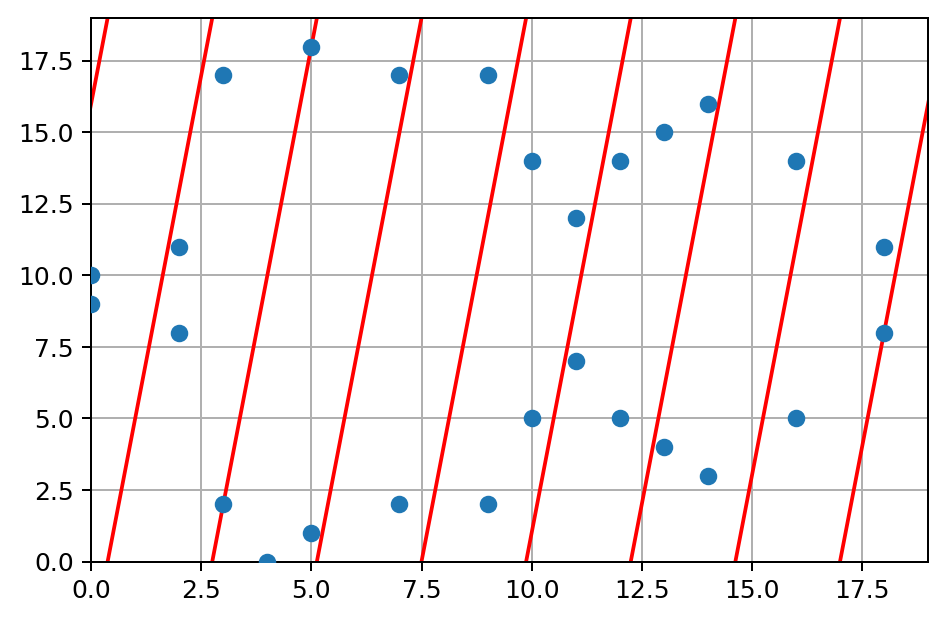

In [192]:
def touch_edge_line(p0, p1):
    dx = p1.x - p0.x
    dy = p1.y - p0.y
    slope = dy / dx
    left_offset_x = -(P - p0.y) / slope
    right_offset_x = -p1.y / slope
    return (
        (p0.x - left_offset_x, P),
        (p1.x + right_offset_x, 0),
    )

fig, ax = plt.subplots()
    
plot_curve(P, A, B, ax)

tp0, tp1 = touch_edge_line(p0, p1)
width = abs(tp1[0] - tp0[0])
left_to_right = True

for i in range(-2, 7):
    ax.add_line(mlines.Line2D([tp0[0] + width * i, tp1[0] + width * i], [P, 0], color='r', zorder=1))
    
plt.show()